In [1]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import h5py
from pathlib import Path
import matplotlib.pyplot as plt
from began import stats
from began.visualization import plot, mplot
from scipy.ndimage import gaussian_filter
from began.optimization import get_l2_loss_and_gradient_function
%matplotlib inline
print("Running on GPU: ", tf.test.is_gpu_available())

Running on GPU:  True


Minimizing a tensorflow model.

In [2]:
gen = tf.keras.models.load_model("/home/bthorne/projects/gan/began/models/generator.h5")

In [102]:
fwhm_in_pix = 30. / 5.
sigma = fwhm_in_pix / np.sqrt(8 * np.log(2))
print('Sigma:', sigma)

Sigma: 2.547965400864057


In [103]:
#for my maps
RES = 256
STEP_SIZE = 4 
GAL_CUT = 16
record_dir = Path("../data/preprocessed/prepared.h5")

with h5py.File(record_dir, 'r') as f:
    x_train = f['norm_maps'][1000, :, :, 0].astype(np.float32)

#x_train = train_images[70, :, :, 0]

# for kevin's maps

#with h5py.File("/home/bthorne/projects/gan/began/data/preprocessed/Planck_dust_cuts_353GHz_norm_log_res256.h5", 'r') as f:
#    x_train = f['200'][:]
#x_train = np.array([i for i in f.values()]).reshape(-1, 256, 256, 1).astype(np.float32)
x_train_smo = gaussian_filter(x_train, sigma)

In [104]:
def l2(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        genned_img = gen(x)[0, :, :, 0]
        loss_value = tf.linalg.norm(genned_img - x_train_smo)
    jac = tape.gradient(loss_value,x)
    loss_value = tf.reshape(loss_value, [1])
    return loss_value,jac

x = tf.Variable(np.random.randn(1, 64).astype(np.float32))
opt = tfp.optimizer.lbfgs_minimize(l2, initial_position=x, tolerance=1e-05, max_iterations=2000)
x_train_prediction = gen(opt.position)
x_train_predictio_smo = gaussian_filter(x_train_prediction, sigma)

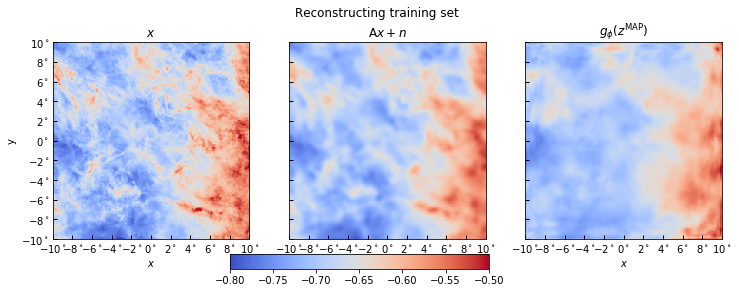

In [105]:
plot_maps = np.concatenate((x_train[None, ...], x_train_smo[None, ...], x_train_prediction[..., 0]))
xlabels = [r"$x$"] * 3
ylabels = [r"y"] + [""] * 2
titles = [r"$x$", r"$\mathsf{A}x + n$", r"$g_\phi(z^{\rm MAP})$"]
fig, axes = mplot(plot_maps, xlabels=xlabels, ylabels=ylabels, titles=titles, extent=[-10, 10, -10, 10], title="Reconstructing training set", cbar_range=[-0.8, -0.5])
fig.savefig("../reports/figures/superresolution.png", bbox_inches='tight', dpi=300)

In [106]:
npix_x = 256
npix_y = 256
ang_x = 20. * np.pi / 180.
ang_y = 20. * np.pi / 180.
aposize = 5

mask = stats.build_flat_mask(npix_x, npix_y, ang_x, ang_y, aposize)
# evaluate the power spectrum of the sampled maps
nmtbin = stats.dimensions_to_nmtbin(npix_x, npix_y, ang_x, ang_y)

autospectra = stats.batch_00_autospectrum(10. ** plot_maps, ang_x, ang_y, mask, nmtbin)

(5e-14, 1e-07)

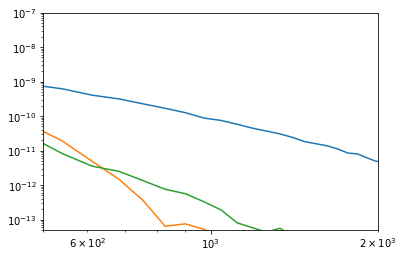

In [107]:
fig, ax=  plt.subplots(1, 1)
ax.loglog(nmtbin.get_effective_ells(), autospectra[0, 0])
ax.loglog(nmtbin.get_effective_ells(), autospectra[1, 0])
ax.loglog(nmtbin.get_effective_ells(), autospectra[2, 0])
ax.set_xlim(500, 2000)
ax.set_ylim(5e-14, 1e-7)
